## DATA

In [1]:
#apikey = "sut582nzqzc8c6utvryxvqecucmbb5dg" #RTU
apikey = "drfk8t5k6tb576ndykq65wwyn3tee3b4" #NTNU
#cloud: https://aranet.cloud/
apiname = "https://aranet.cloud/openapi/#/"


In [2]:
import pandas as pd
import numpy as np
from collections import namedtuple
from dataclasses import dataclass
from datetime import datetime, timezone, timedelta
import requests
import json

In [3]:
class pyAranetDashboard(object):
    # --- constructor ---
    def __init__(self, api = "https://aranet.cloud/api/", apikey = ""):

        # initiate api creds (url_base and key) from provided file
        self.__api_url_base = api
        self.__api_key = apikey

        # initiate base requests from aranet (bases metrics sensors)
        self.__init_requests()

        # populates dict with id's and respective sensor, metric and unit names
        self.__init_names()

    #  --- Sends a request for data and returns the raw json file  ---
    def request_data(self, req, sensor_ids=None, last_n_mins=None, days = None, log=False):

        # Forms url for intended request
        if req is not None and sensor_ids is None and last_n_mins is None and days is None:
            api_url = '{0}{1}'.format(self.__api_url_base, req)
            print(api_url)

        elif req == self.__reqs.history and sensor_ids is not None and last_n_mins is not None:
            api_url = '{0}{1}?sensor={2}&minutes={3}'.format(
                self.__api_url_base, req, sensor_ids, last_n_mins)
            
        elif req == self.__reqs.history and sensor_ids is not None and days is not None:
            api_url = '{0}{1}?sensor={2}&days={3}'.format(
                self.__api_url_base, req, sensor_ids, days)

        else:
            print("ERR in pyAranetDashboard -> get_data():\n  ")
            return None

        # Creates header and sends request
        headers = {
            'accept': 'application/json',
            'ApiKey': '{0}'.format(self.__api_key),
        }
        try:
            response = requests.get(api_url, headers=headers)
            SC = response.status_code
        except Exception as e:
            print("ERR in pyAranetDashboard -> get_data():\n  {0}".format(e))
            return None

        # IF log THEN Outputs the response status code
        if log:
            print("pyAranetDashboard -> \n  Request: GET {0}\n  Response: {1} - {2}".format(
                api_url, SC, self.__status_code_name[SC]))

        # Returns the data or None
        if SC == 200:
            return json.loads(response.text)
        else:
            return None
    
    
    # --- Initializes requests ---
    def __init_requests(self):
        nontupl = ()
        for i in range(len(self.__All_requests.__annotations__)):
            nontupl += (None,)
        print(nontupl)
        self.__reqs = self.__All_requests(*nontupl)
    
    def get_reqs(self):
        return self.__reqs

    # --- Requests all sensors, metrics and units from server and populates dicts ---
    def __init_names(self):
        json_data = self.request_data(self.__reqs.metrics)
        df = pd.json_normalize(json_data["metrics"])
        df = df.reset_index()
        for _, row in df.iterrows():
            self.__metrics_names[row['id']] = row['name']

        df = pd.json_normalize(json_data['metrics'],
                               record_path=['units'])

        df = df.reset_index()
        for _, row in df.iterrows():
            self.__unit_names[row['id']] = row['name']

        json_data = self.request_data(self.__reqs.sensors)
        df = pd.json_normalize(json_data['sensors'])
        df = df.reset_index()
        for _, row in df.iterrows():
            self.__sensor_names[row['id']] = row['name']

    # --- Packs the json file into a Pandas data frame ---   
    def get_df(self, req, sensor_ids=None, last_n_mins=None, days = None, all_sensors=None, log=False):

        # Handles base requests
        if req is not None and sensor_ids is None and last_n_mins is None and days is None:
            json_data = self.request_data(req, log=log)
            #print(json_data)

        # Handles multiple sensor history requests
        elif req is self.__reqs.history and last_n_mins is not None:

            if sensor_ids is not None:

                if type(sensor_ids) is list:
                    sensor_ids = '%2C'.join(sensor_ids)

            elif all_sensors:
                sensor_ids = '%2C'.join(self.__sensor_names.keys())

            json_data = self.request_data(
                req, sensor_ids, last_n_mins, log=log)
        # Handles multiple sensor history requests
        elif req is self.__reqs.history and days is not None:

            if sensor_ids is not None:

                if type(sensor_ids) is list:
                    sensor_ids = '%2C'.join(sensor_ids)

            elif all_sensors:
                sensor_ids = '%2C'.join(self.__sensor_names.keys())

            json_data = self.request_data(
                req, sensor_ids, days = days, log=log)
            print(json_data)

        # Returns None if arguments don't match
        else:
            print(req)
            print("ERR in pyAranetDashboard -> get_data():\n  ")
            return None
        # Returns None if json is empty
        if json_data == None:
            print("get_df() failed")
            return None

        # Formats the sensors DF
        elif req == self.__reqs.sensors:
            print(
                "INF pyAranetDashboard -> get_df():\n  packing 'sensors', dropping 'links'")
            df = pd.json_normalize(json_data['sensors'],
                                   record_path=['skills'],
                                   meta=[
                'id',
                'sensorId',
                'name',
                'type',
                'bases',
            ])

        # Fromtas the metrics DF
        elif req == self.__reqs.metrics:
            df = pd.json_normalize(json_data['metrics'],
                                   record_path=['units'],
                                   meta=[
                'id',
                'name',
            ],
                record_prefix='unit_')

            print(
                "INF pyAranetDashboard -> get_df():\n  packing 'metrics', dropping not-default")
            df = df.dropna()

        # Formats the bases DF
        elif req == self.__reqs.bases:
            df = pd.json_normalize(json_data['bases'])

        # Formats the history DF
        elif req == self.__reqs.history:
            try:
                df = pd.json_normalize(json_data['readings'])
            except Exception as e:
                print(
                    "ERR in pyAranetDashboard -> get_df():\n  {0} - try increasing time frame (no measurements received)".format(e))
                if log:
                    print("sensor_ids: {0}".format(sensor_ids))
                return None

        return df
        # --- Adds sensor locations to the DF ---
    def add_locations_to_df(self, df):
        if df is not None:
            df['type'] = df['sensor'].apply(self.__get_stype)
            df['floor'] = df['sensor'].apply(self.__get_sfloor)
            df['room'] = df['sensor'].apply(self.__get_sroom)
            return df
        else:
            print("ERR  add_locations_to_df -> provided df is None!")
            return None

    # --- Returns the available requests for dashboard ---

    def get_reqs(self):
        return self.__reqs

    # --- Prints or fills a list with available sensors ---
    def available_sensors(self, log=True):
        # IF log THEN prints available sensors to command line
        if log:
            print("available sensors:")
            if len(self.__sensor_names) != 0:
                for k, v in self.__sensor_names.items():
                    print("  ", k, v)
            else:
                print("None")

        # If a list is provided, it gets filled with sensor names
        return self.__sensor_names

    # --- Converts metric ids to names ---
    def metric_name(self, id):
        return self.__metrics_names[id]

    # --- Converts sensor ids to names ---
    def sensor_name(self, id):
        return self.__sensor_names[id]

    # --- Converts unit ids to names ---
    def unit_name(self, id):
        return self.__unit_names[id]

    # --- Extracts date from stamp ---
    def extract_date(self, date_time):
        # 2023-01-13T15:27:32Z
        return date_time.strftime("%Y-%m-%d")

    # --- Extracts time from stamp ---
    def extract_time(self, date_time):
        return date_time.strftime("%H:%M:%S")

    def convert_timezone(self, date_time):
        dt = datetime.strptime(date_time, "%Y-%m-%dT%H:%M:%SZ")
        dt = dt.replace(tzinfo=timezone.utc).astimezone(
            tz=timezone(timedelta(hours=2, minutes=0), "Europe/Riga"))
        return dt
    
    # --- Prints or fills a list with available sensors ---
    def available_sensors(self, log=True):
        # IF log THEN prints available sensors to command line
        if log:
            print("available sensors:")
            if len(self.__sensor_names) != 0:
                for k, v in self.__sensor_names.items():
                    print("  ", k, v)
            else:
                print("None")

        # If a list is provided, it gets filled with sensor names
        return self.__sensor_names

    # --- Makes a sensor message readable by replacing ids with names ---
    def make_sensor_df_readable(self, df, include_seperate_date_and_time=True):
        if df is not None:
            df['sensorid'] = df['sensor']
            df['metric'] = df['metric'].apply(self.metric_name)
            df['sensor'] = df['sensor'].apply(self.sensor_name)
            df['unit'] = df['unit'].apply(self.unit_name)
            if include_seperate_date_and_time:
                df['datetime'] = df['time'].apply(self.convert_timezone)
                df['date'] = df['datetime'].apply(self.extract_date)
                df['time'] = df['datetime'].apply(self.extract_time)
            else:
                df['time'] = df['time'].apply(self.convert_timezone)

        else:
            print("ERR  make_sensor_df_readable -> provided df is None!")
        return df

    #  PRIVATE VARIABLES

    __api_url_base = ''
    __api_key = ''
    __status_code_name = {200: "Request OK", 404: "Not Found",
                          500: "Internal server error", 400: "Bad Request"}
    __metrics_names = dict()
    __unit_names = dict()
    __sensor_names = dict()

    @dataclass
    class __All_requests:
          bases: str
          metrics: str
          sensors: str
          history: str

          def __post_init__(self):
            if self.bases is None:
                self.bases = 'v1/bases'
            if self.metrics is None:
                self.metrics = 'v1/metrics'
            if self.sensors is None:
                self.sensors = 'v1/sensors'
            if self.history is None:
                self.history = 'v1/measurements/history'

In [4]:
dashboard = pyAranetDashboard(apikey = apikey)
reqs = dashboard.get_reqs()

(None, None, None, None)
https://aranet.cloud/api/v1/metrics
https://aranet.cloud/api/v1/sensors


In [5]:
# # --- Get all bases as a data frame ---
df_bases = dashboard.get_df(reqs.bases)
print("\n",df_bases)

https://aranet.cloud/api/v1/bases

              id           name                      regdate firmware upgrade  \
0  352311003575  AranetBS_B315  2023-01-03T12:17:12.158585Z   v3.2.5  v3.3.6   
1  352311004859  Aranet-05121c  2022-12-05T07:52:17.655712Z   v3.1.7  v3.3.6   
2  352400104585  Aranet-4e7032   2022-11-08T09:37:54.26999Z   v3.1.7  v3.3.6   

        product board region                             self  \
0  TDSBWPA1.050  WR12     EU  /api/v1/bases/base/352311003575   
1  TDSBWPA1.050  WR12     EU  /api/v1/bases/base/352311004859   
2      TDSBOB03  PR04     EU  /api/v1/bases/base/352400104585   

                             sensors  
0  /api/v1/sensors?base=352311003575  
1  /api/v1/sensors?base=352311004859  
2  /api/v1/sensors?base=352400104585  


In [6]:
a = df_bases['name']
print(a.shape[0])

3


In [7]:
# # # --- Get a dict of all sensors available ---
sensors = dashboard.available_sensors(log=False)
print(sensors)

{'1058809': '', '4215161': 'Room L163', '4215162': 'Room B311', '4215164': 'Room L165', '4215168': 'Room L167', '4215169': 'Room L167', '4215175': 'Room L044', '4215190': 'Room L160', '4215199': '', '4215282': 'Room L163', '4215293': '', '4215296': 'Room B315', '4215302': 'Room L165', '4215317': 'Room B310', '4216041': 'Room L044', '4216120': 'Room L160', '4216207': 'Room B314', '5246843': 'Dør sensor L044'}


In [8]:
df_sensors = dashboard.get_df(reqs.sensors)

https://aranet.cloud/api/v1/sensors
INF pyAranetDashboard -> get_df():
  packing 'sensors', dropping 'links'


In [9]:
sensors_list = np.unique(df_sensors['id'])[1:].tolist()
print(sensors_list)

['4215161', '4215162', '4215164', '4215168', '4215169', '4215175', '4215190', '4215199', '4215282', '4215293', '4215296', '4215302', '4215317', '4216041', '4216120', '4216207', '5246843']


In [10]:
  # --- Get readings of select sensors as a data frame ---   
  df_select_sensors = dashboard.get_df(reqs.history, sensor_ids=['4215169'], days=1,last_n_mins=None, log=True)      
  df_sensordata = dashboard.make_sensor_df_readable(df_select_sensors)
  df_sensordata

pyAranetDashboard -> 
  Request: GET https://aranet.cloud/api/v1/measurements/history?sensor=4215169&days=1
  Response: 200 - Request OK
{'readings': [{'metric': '1', 'sensor': '4215169', 'unit': '1', 'time': '2023-04-26T00:00:50Z', 'value': 21.7}, {'metric': '1', 'sensor': '4215169', 'unit': '1', 'time': '2023-04-26T00:01:52Z', 'value': 21.7}, {'metric': '1', 'sensor': '4215169', 'unit': '1', 'time': '2023-04-26T00:02:49Z', 'value': 21.7}, {'metric': '1', 'sensor': '4215169', 'unit': '1', 'time': '2023-04-26T00:03:52Z', 'value': 21.7}, {'metric': '1', 'sensor': '4215169', 'unit': '1', 'time': '2023-04-26T00:04:51Z', 'value': 21.7}, {'metric': '1', 'sensor': '4215169', 'unit': '1', 'time': '2023-04-26T00:05:50Z', 'value': 21.7}, {'metric': '1', 'sensor': '4215169', 'unit': '1', 'time': '2023-04-26T00:06:51Z', 'value': 21.7}, {'metric': '1', 'sensor': '4215169', 'unit': '1', 'time': '2023-04-26T00:07:50Z', 'value': 21.7}, {'metric': '1', 'sensor': '4215169', 'unit': '1', 'time': '2023-0

,metric,sensor,unit,time,value,sensorid,datetime,date
0,Temperature,Room L167,°C,02:00:50,21.7,4215169,2023-04-26 02:00:50+02:00,2023-04-26
1,Temperature,Room L167,°C,02:01:52,21.7,4215169,2023-04-26 02:01:52+02:00,2023-04-26
2,Temperature,Room L167,°C,02:02:49,21.7,4215169,2023-04-26 02:02:49+02:00,2023-04-26
3,Temperature,Room L167,°C,02:03:52,21.7,4215169,2023-04-26 02:03:52+02:00,2023-04-26
4,Temperature,Room L167,°C,02:04:51,21.7,4215169,2023-04-26 02:04:51+02:00,2023-04-26
...,...,...,...,...,...,...,...,...
2463,Atmospheric Pressure,Room L167,hPa,12:13:58,1009.0,4215169,2023-04-26 12:13:58+02:00,2023-04-26
2464,Atmospheric Pressure,Room L167,hPa,12:14:57,1009.0,4215169,2023-04-26 12:14:57+02:00,2023-04-26
2465,Atmospheric Pressure,Room L167,hPa,12:15:57,1009.0,4215169,2023-04-26 12:15:57+02:00,2023-04-26
2466,Atmospheric Pressure,Room L167,hPa,12:16:57,1009.0,4215169,2023-04-26 12:16:57+02:00,2023-04-26


In [11]:
  print("\n",df_sensordata.describe())


              value
count  2468.000000
mean    397.850851
std     412.734146
min      21.000000
25%      22.900000
50%     210.500000
75%     807.250000
max    1009.000000


In [12]:
print(df_sensordata.head())

        metric     sensor unit      time  value sensorid  \
0  Temperature  Room L167   °C  02:00:50   21.7  4215169   
1  Temperature  Room L167   °C  02:01:52   21.7  4215169   
2  Temperature  Room L167   °C  02:02:49   21.7  4215169   
3  Temperature  Room L167   °C  02:03:52   21.7  4215169   
4  Temperature  Room L167   °C  02:04:51   21.7  4215169   

                   datetime        date  
0 2023-04-26 02:00:50+02:00  2023-04-26  
1 2023-04-26 02:01:52+02:00  2023-04-26  
2 2023-04-26 02:02:49+02:00  2023-04-26  
3 2023-04-26 02:03:52+02:00  2023-04-26  
4 2023-04-26 02:04:51+02:00  2023-04-26  


In [13]:
print(df_sensordata.tail())

                    metric     sensor unit      time   value sensorid  \
2463  Atmospheric Pressure  Room L167  hPa  12:13:58  1009.0  4215169   
2464  Atmospheric Pressure  Room L167  hPa  12:14:57  1009.0  4215169   
2465  Atmospheric Pressure  Room L167  hPa  12:15:57  1009.0  4215169   
2466  Atmospheric Pressure  Room L167  hPa  12:16:57  1009.0  4215169   
2467  Atmospheric Pressure  Room L167  hPa  12:17:59  1009.0  4215169   

                      datetime        date  
2463 2023-04-26 12:13:58+02:00  2023-04-26  
2464 2023-04-26 12:14:57+02:00  2023-04-26  
2465 2023-04-26 12:15:57+02:00  2023-04-26  
2466 2023-04-26 12:16:57+02:00  2023-04-26  
2467 2023-04-26 12:17:59+02:00  2023-04-26  


## ARIMA

In [14]:
# == preparing dataset
DfData = df_sensordata[(df_sensordata['metric'] == 'Temperature') & (df_sensordata['sensorid'] == '4215169')]['value']
DfData = DfData.to_frame().reset_index()
print(type(DfData))
print(DfData.index)
print(DfData.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex(start=0, stop=617, step=1)
   index  value
0      0   21.7
1      1   21.7
2      2   21.7
3      3   21.7
4      4   21.7


In [15]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(DfData.value, order = (1,1,1))
model = arima_model.fit()
print(model.summary())


                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  617
Model:                 ARIMA(1, 1, 1)   Log Likelihood                1241.426
Date:                Wed, 26 Apr 2023   AIC                          -2476.852
Time:                        10:18:36   BIC                          -2463.582
Sample:                             0   HQIC                         -2471.692
                                - 617                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1599      0.061     -2.642      0.008      -0.279      -0.041
ma.L1         -0.3476      0.063     -5.520      0.000      -0.471      -0.224
sigma2         0.0010   3.56e-05     29.192      0.0

493 617


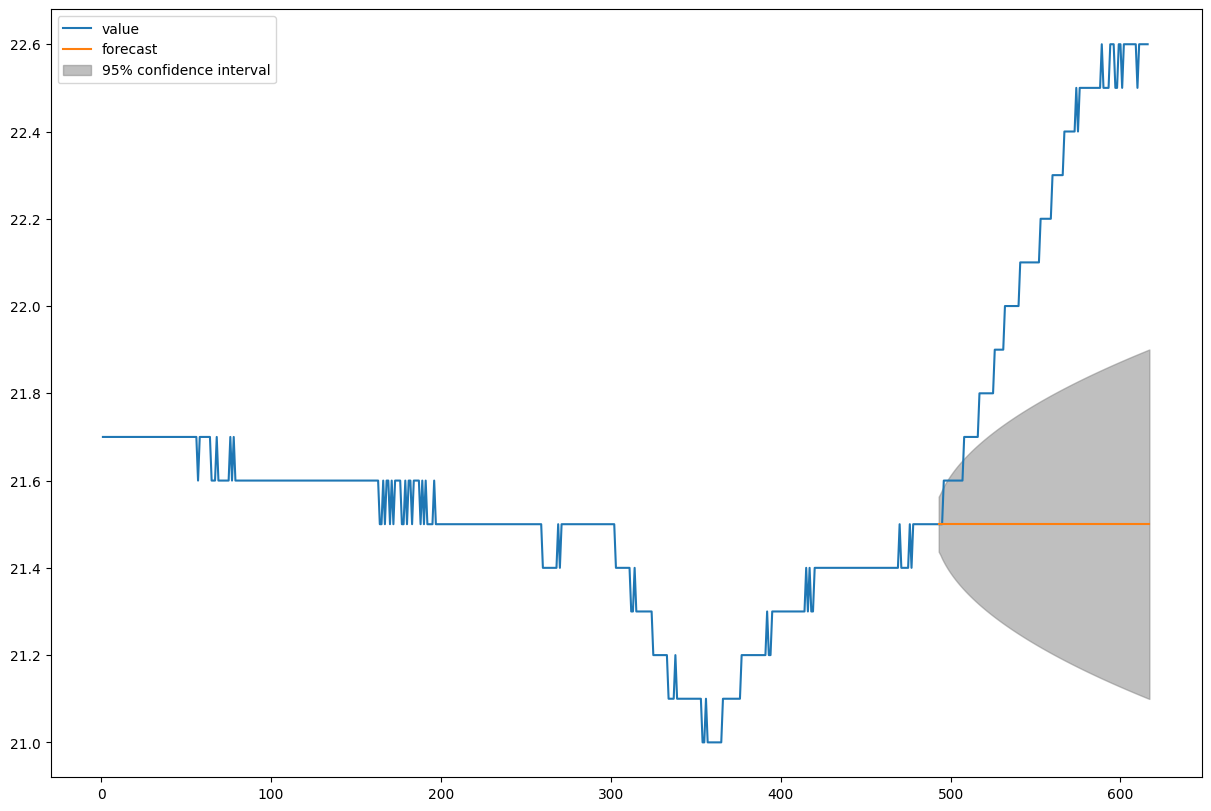

In [16]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_predict

start = int(DfData.shape[0] - 0.2 * DfData.shape[0])
end = int(DfData.shape[0])

points = model.predict(start,end, dynamic = True)
points = points.to_frame().reset_index()

print(start, end)

fig, ax = plt.subplots(1, 1, figsize=(12, 8),constrained_layout=True)
ax = DfData.loc[1:]['value'].plot(ax=ax)
fig = plot_predict(model,start, end, dynamic=True, ax=ax)
plt.show()


## ARIMA in demo mode

493 617


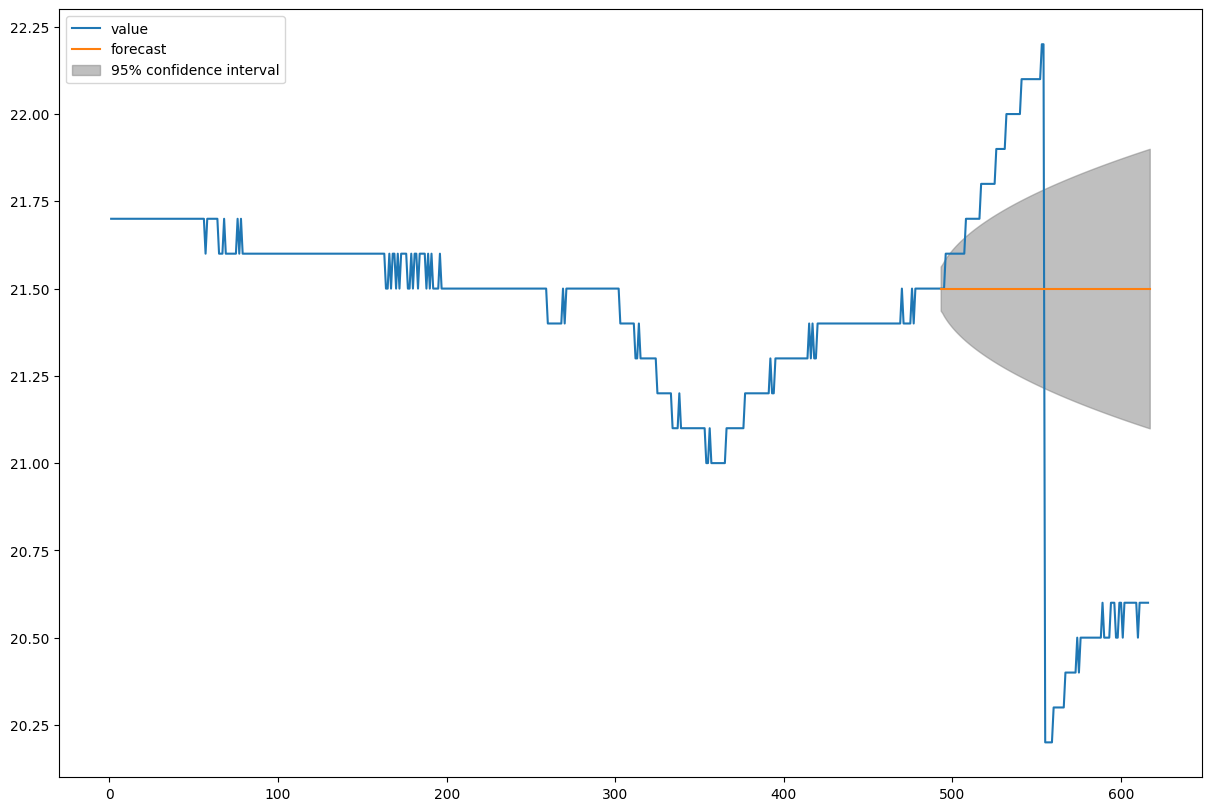

In [17]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_predict

start = int(DfData.shape[0] - 0.2 * DfData.shape[0])
end = int(DfData.shape[0])

points = model.predict(start,end, dynamic = True)
points = points.to_frame(name = "value")

#print(points)
print(start, end)

# === demo mode data modification ===============
for i in range(int(DfData.shape[0] - 0.1 * DfData.shape[0]),end):
    DfData.loc[i,'value'] = DfData.loc[i,'value'] - 2.0


window = 3
anomaliesdetected = 0
for i in range(start,end):
    if(abs(points.loc[i,'value'] - DfData.loc[i,'value']) > 0.1 * DfData.loc[i,'value']):
      anomaliesdetected = anomaliesdetected + 1
if (anomaliesdetected > window):
  print("Alert detected")


fig, ax = plt.subplots(1, 1, figsize=(12, 8),constrained_layout=True)
ax = DfData.loc[1:]['value'].plot(ax=ax)
fig = plot_predict(model,start, end, dynamic=True, ax=ax)
plt.show()